<h1 style="text-align: center">CURSOS PROUNI</h1>
<hr>    


A base de dados que utilizamos ao decorrer do trabalho pode ser encontrada [aqui](https://brasil.io/dataset/cursos-prouni/cursos/)

ou no link: https://brasil.io/dataset/cursos-prouni/cursos/

### Importando bibliotecas

In [1]:
import os
import sys
import time
import datetime

import pandas as pd
import geopandas
import numpy as np

import sqlite3 

import unicodedata
import matplotlib.pyplot as plt
from tabulate import tabulate

<hr>

### Acessando o banco SQLite

In [2]:
# fazendo a conexão
conn = sqlite3.connect(os.path.join('cursos_prouni.sqlite'))
cur = conn.cursor()

In [3]:
# query selecionando todas as entradas da tabela
cur.execute('''  
SELECT * FROM cursos_prouni
          ''')

# transformando em um dataframe pandas
df = pd.DataFrame(cur.fetchall(), columns=['grau', 'turno', 'mensalidade', 'bolsa_integral_cotas', 'bolsa_integral_ampla', 'bolsa_parcial_cotas', 'bolsa_parcial_ampla', 'curso_id', 'curso_busca', 'cidade_busca', 'uf_busca', 'cidade_filtro', 'universidade_nome', 'campus_nome', 'campus_id', 'nome','nota_integral_ampla', 'nota_integral_cotas', 'nota_parcial_ampla','nota_parcial_cotas'])    

<hr>

### Testes iniciais e mudanças críticas

In [4]:
# informações do banco
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41447 entries, 0 to 41446
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   grau                  41447 non-null  object 
 1   turno                 41447 non-null  object 
 2   mensalidade           41447 non-null  float64
 3   bolsa_integral_cotas  32520 non-null  float64
 4   bolsa_integral_ampla  25404 non-null  float64
 5   bolsa_parcial_cotas   8828 non-null   float64
 6   bolsa_parcial_ampla   13041 non-null  float64
 7   curso_id              41447 non-null  int64  
 8   curso_busca           41447 non-null  object 
 9   cidade_busca          41447 non-null  object 
 10  uf_busca              41447 non-null  object 
 11  cidade_filtro         41447 non-null  object 
 12  universidade_nome     41447 non-null  object 
 13  campus_nome           41447 non-null  object 
 14  campus_id             41447 non-null  int64  
 15  nome               

A ideia incial era fazer visualizações por município, e verificar a incidencia de bolsas e cotas em cada um. Porém, há alguns problemas envolvidos com a escolha da base de dados que nos impediu de prosseguir com esse plano.

Pretendiamos tirar proveito das colunas referentes às localizações, fazendo um Join entre elas e as colunas com informações da geometria, possibilitando visualizações interessantes.
A coluna de cidade provavelmente possui complicações, pois mesmo fazendo um esforço considerável para deixar ela simplificada (remoção de acentos, maiúsculas, etc...) é provável que ocorram casos em que nomes fiquem sem nenhum match por estarem escritos de maneiras diferentes, resultando em buracos na visualização.

Como o mapa com as geometrias de todo o Brasil é muito pesado, iniciaremos montando uma visualização no Acre e depois no Rio de Janeiro (para ter uma ideia melhor de como ficam os plots).

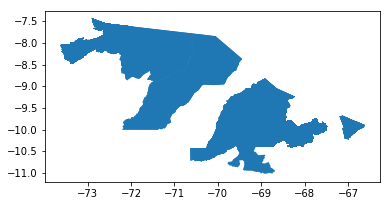

In [5]:
import unicodedata

UF="AC"
file = open("geojs-12-mun.json")
geodata = geopandas.read_file(file)
#df=df.loc[df["uf_busca"]==UF]
df.rename(columns={'cidade_busca':'name'}, inplace=True)
c="name"

df[c]=df[c].str.lower().map(lambda x: unicodedata.normalize('NFKD', x)).str.encode('ascii', 'ignore')
geodata[c]=geodata[c].str.lower().map(lambda x: unicodedata.normalize('NFKD', x)).str.encode('ascii', 'ignore')

df3=pd.merge(df,geodata,on="name")
gdf3 = geopandas.GeoDataFrame(
    df3, geometry=df3["geometry"])
gdf3.plot()

Algo claramente já deu errado, por possuir poucas cidades, é viavel comparar a lista de cidades do estado do Acre, com as que possuem informações no nosso Dataset.

In [6]:
print(geodata['name'].apply(lambda x: str(x)[2:-1]))
print("Lista dos que constam no dataset: ",df[df["uf_busca"] == "AC"]['name'].apply(lambda x: str(x)[2:-1]).unique(),
      len(df[df["uf_busca"] == "AC"]['name'].unique())," entradas de ", len(geodata['name'].unique()) ,"esperadas")

0               acrelandia
1             assis brasil
2                brasileia
3                   bujari
4                 capixaba
5          cruzeiro do sul
6           epitaciolandia
7                    feijo
8                   jordao
9              mancio lima
10           manoel urbano
11    marechal thaumaturgo
12       placido de castro
13            porto walter
14              rio branco
15         rodrigues alves
16     santa rosa do purus
17        senador guiomard
18          sena madureira
19                tarauaca
20                  xapuri
21              porto acre
Name: name, dtype: object
Lista dos que constam no dataset:  ['rio branco' 'cruzeiro do sul' 'acrelandia' 'brasileia' 'sena madureira'
 'tarauaca' 'feijo'] 7  entradas de  22 esperadas


Acre esperado:

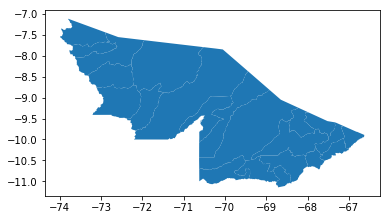

In [7]:
geodata.plot()

Nesse momento percebermos que o problema não foi necessáriamente a mescla, mas sim o fato de que nem todas as cidades constam no dataset.
Comparando com o estado do RJ, podemos verificar se existem muitos "buracos" e ter certeza se o problema é somente com o  Acre ou se é um problema nacional.

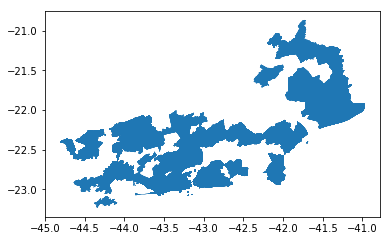

In [8]:
UF="RJ"
file = open("geojs-33-mun.json")
geodata = geopandas.read_file(file)

geodata[c]=geodata[c].str.lower().map(lambda x: unicodedata.normalize('NFKD', x)).str.encode('ascii', 'ignore')

df3=pd.merge(df,geodata,on="name")
gdf3 = geopandas.GeoDataFrame(
    df3, geometry=df3["geometry"])
gdf3.plot()

Como o mapa do RJ também está falhado decidimos alterar a escala de municipal para estadual.

<hr>

### Criação do banco com as geometrias

In [9]:
# criando e conectando ao databa_teste
conn = sqlite3.connect('database_states')
c = conn.cursor()

In [10]:
# lendo o arquivo json dos estados brasileiros
file = open("br-states.json")
geodata = geopandas.read_file(file)
geodata = geodata.astype('str', copy=True, errors='raise')

In [11]:
# criando a tabela estados_geojson
c.execute('CREATE TABLE IF NOT EXISTS estados_geojson (id number, uf text, nome text, geometry text)')
conn.commit()

# guardando as informações em estadoBR
geodata.to_sql('estadosBr', conn, if_exists='replace', index = False)
conn.commit()

In [12]:
# acessando as informações do banco
c.execute('''  
SELECT * FROM estadosBr
          ''')

df_provisorio = pd.DataFrame(c.fetchall())
print (df_provisorio.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       27 non-null     object
 1   1       27 non-null     object
 2   2       27 non-null     object
dtypes: object(3)
memory usage: 776.0+ bytes
None


Note que por ser um banco SQLite, não possuí o datatype para a coluna geometria. Então a transformamos em texto, para posteriormente, voltar para geometria.

In [13]:
# Voltando para o tipo geometria do pandas
df_provisorio[2] = geopandas.GeoSeries.from_wkt(df_provisorio[2])
df_provisorio.rename(columns={0:'id',1:'name',2:'geometry'}, inplace=True)

# Transofrmando em um df do geopandas
geodata = geopandas.GeoDataFrame(df_provisorio, geometry='geometry')

In [14]:
geodata.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        27 non-null     object  
 1   name      27 non-null     object  
 2   geometry  27 non-null     geometry
dtypes: geometry(1), object(2)
memory usage: 776.0+ bytes




O mapa que utilizaremos será:

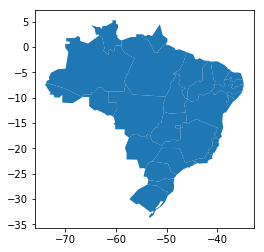

In [15]:
geodata.plot()

<hr>

### Visualizações em escala estadual :

As visualizações que faremos serão:
    
 - Relação entre mensalidade e as notas médias em cada categoria
 - Relação entre mensalidade e o desvio padrão das notas em cada categoria
 - Relação entre mensalidade e a média de bolsas dadas em cada categoria
 
Sendo que a primeira visualização de cada bloco será o mapa das mensalidades

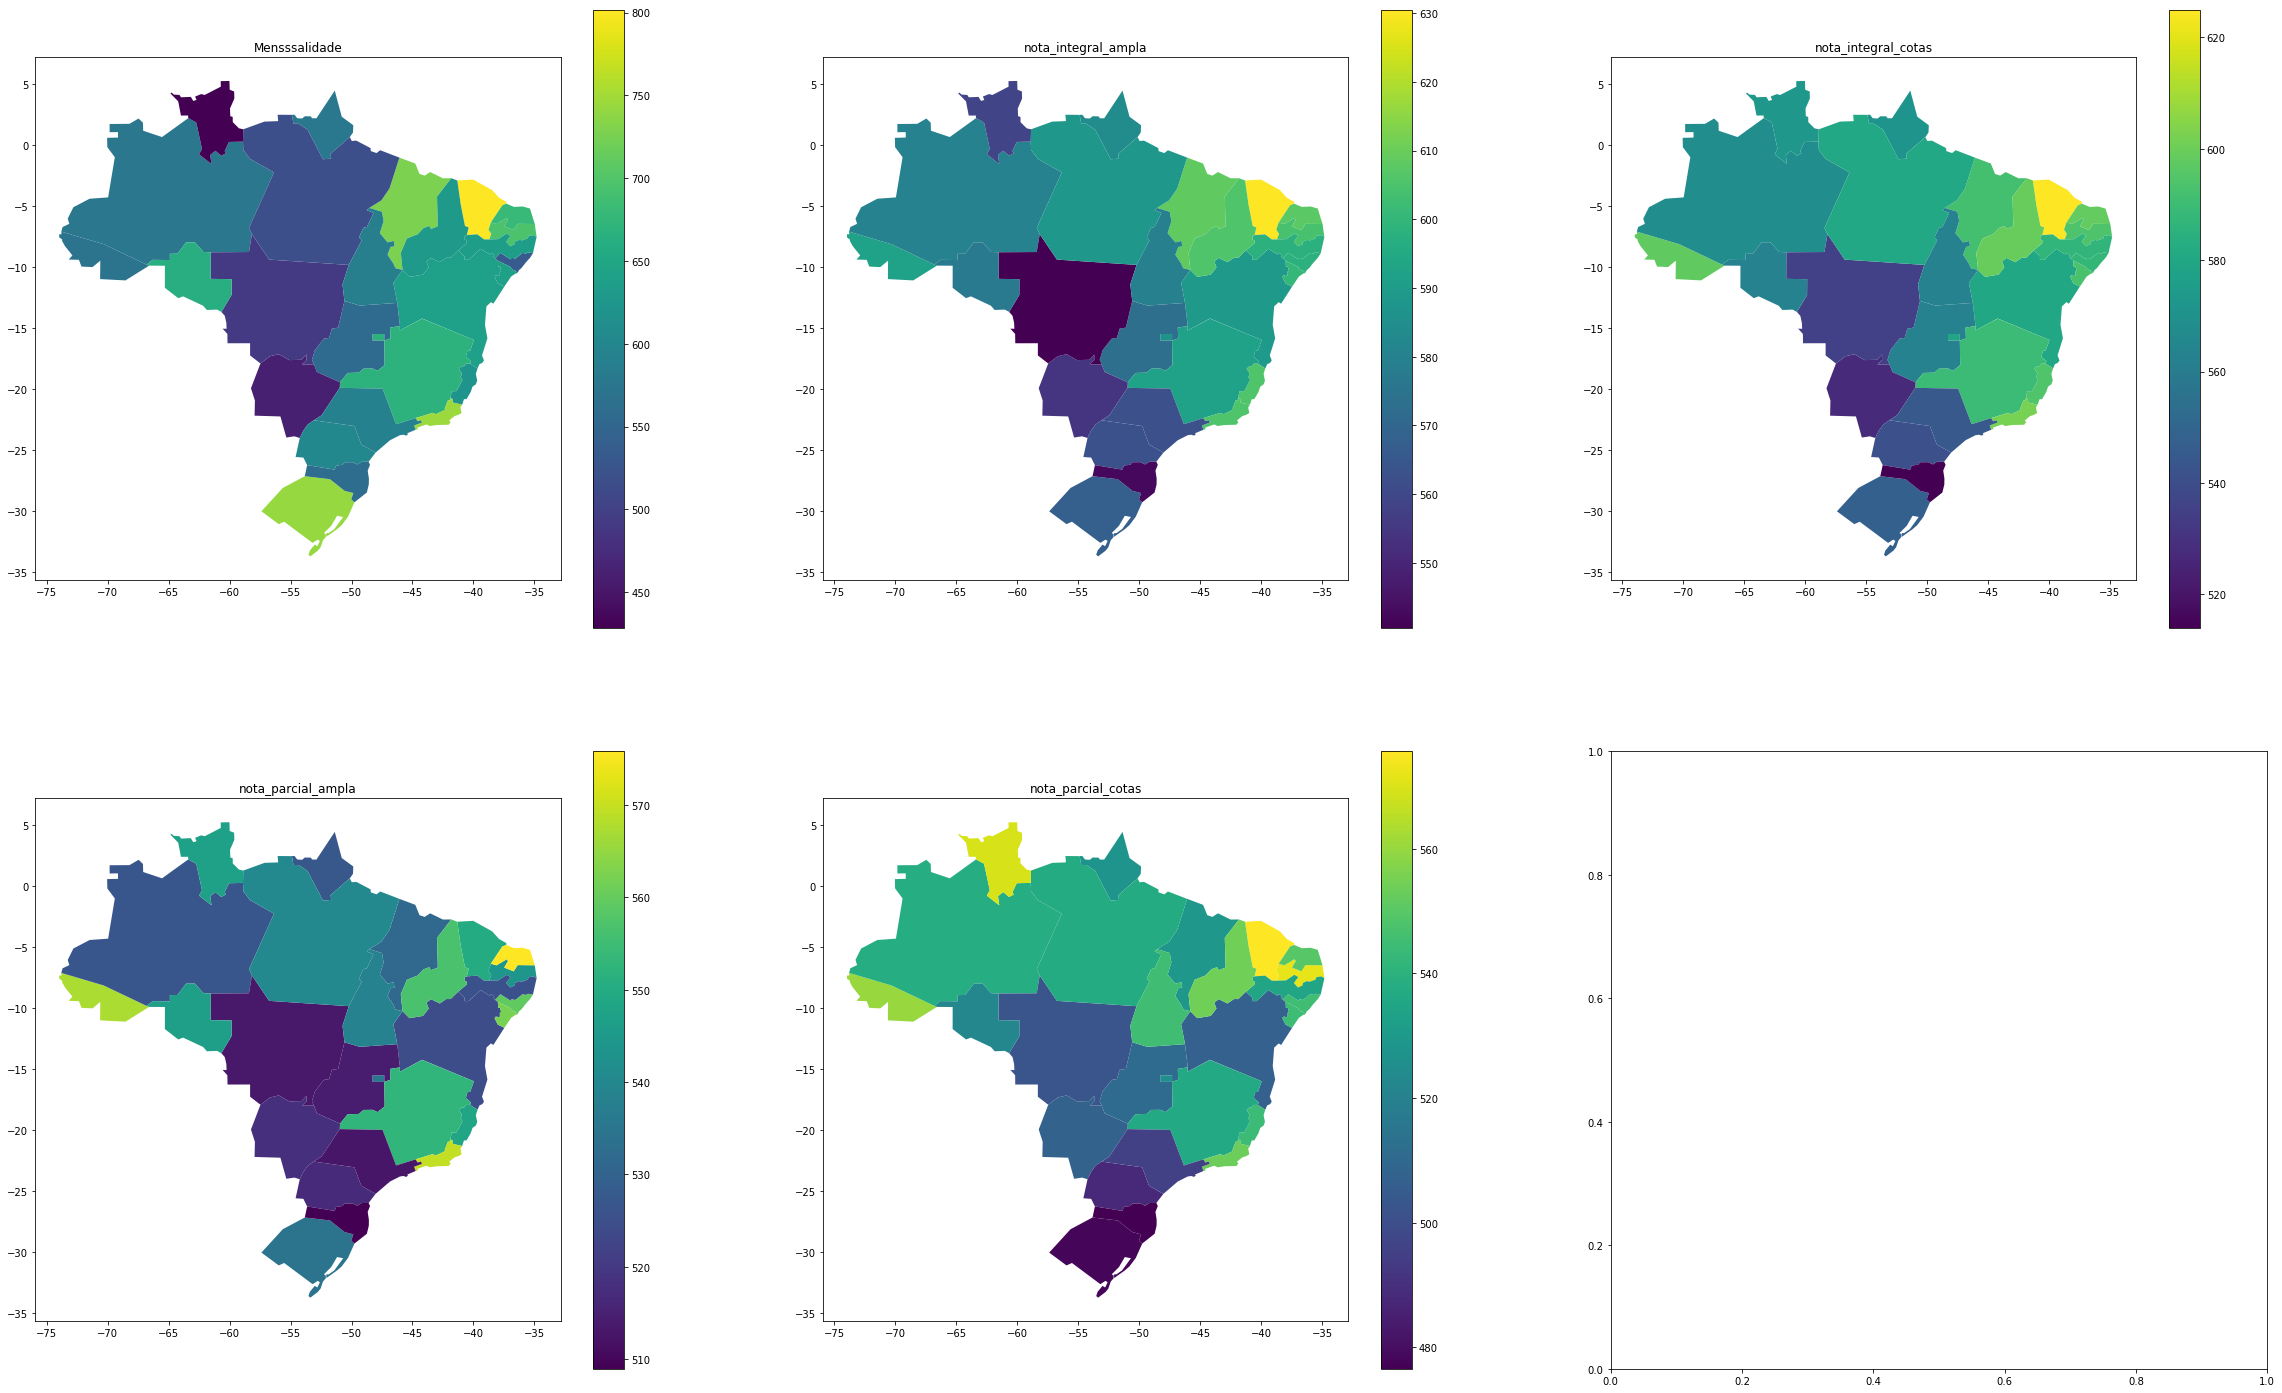

In [16]:
# Agrupando ambos os databases (com as informações do prouni e o com as geometrias) pela coluna id, utilizando 
# a média das linhas

df.rename(columns={'uf_busca':'id'}, inplace=True)
df1=df.groupby("id").mean()

df3=pd.merge(df1,geodata,on="id")
gdf3 = geopandas.GeoDataFrame(
    df3, geometry=df3["geometry"])

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=[40,25])

# Fazendo visualizações das notas (média) por estado

axes[0][0].set_title("Mensalidade")
axes[0][1].set_title("nota_integral_ampla")
axes[0][2].set_title("nota_integral_cotas")
axes[1][0].set_title("nota_parcial_ampla")
axes[1][1].set_title("nota_parcial_cotas")

gdf3.plot(column="mensalidade", ax=axes[0][0], legend=True)
gdf3.plot(column="nota_integral_ampla", ax=axes[0][1], legend=True)
gdf3.plot(column="nota_integral_cotas", ax=axes[0][2], legend=True)
gdf3.plot(column="nota_parcial_ampla", ax=axes[1][0], legend=True)
gdf3.plot(column="nota_parcial_cotas", ax=axes[1][1], legend=True)


Nos plots acima é possível ter uma noção das distribuições das notas, um pouco da diferença entre as notas parciais e integrais, além de comparar as categorias de concorrência ampla ou em cotas. Tudo isso também pode trazer ideias interessantes ao comparar com a distribuição das maiores mensalidades no primeiro mapa. (E certamente chama atenção para o estado do Ceará).

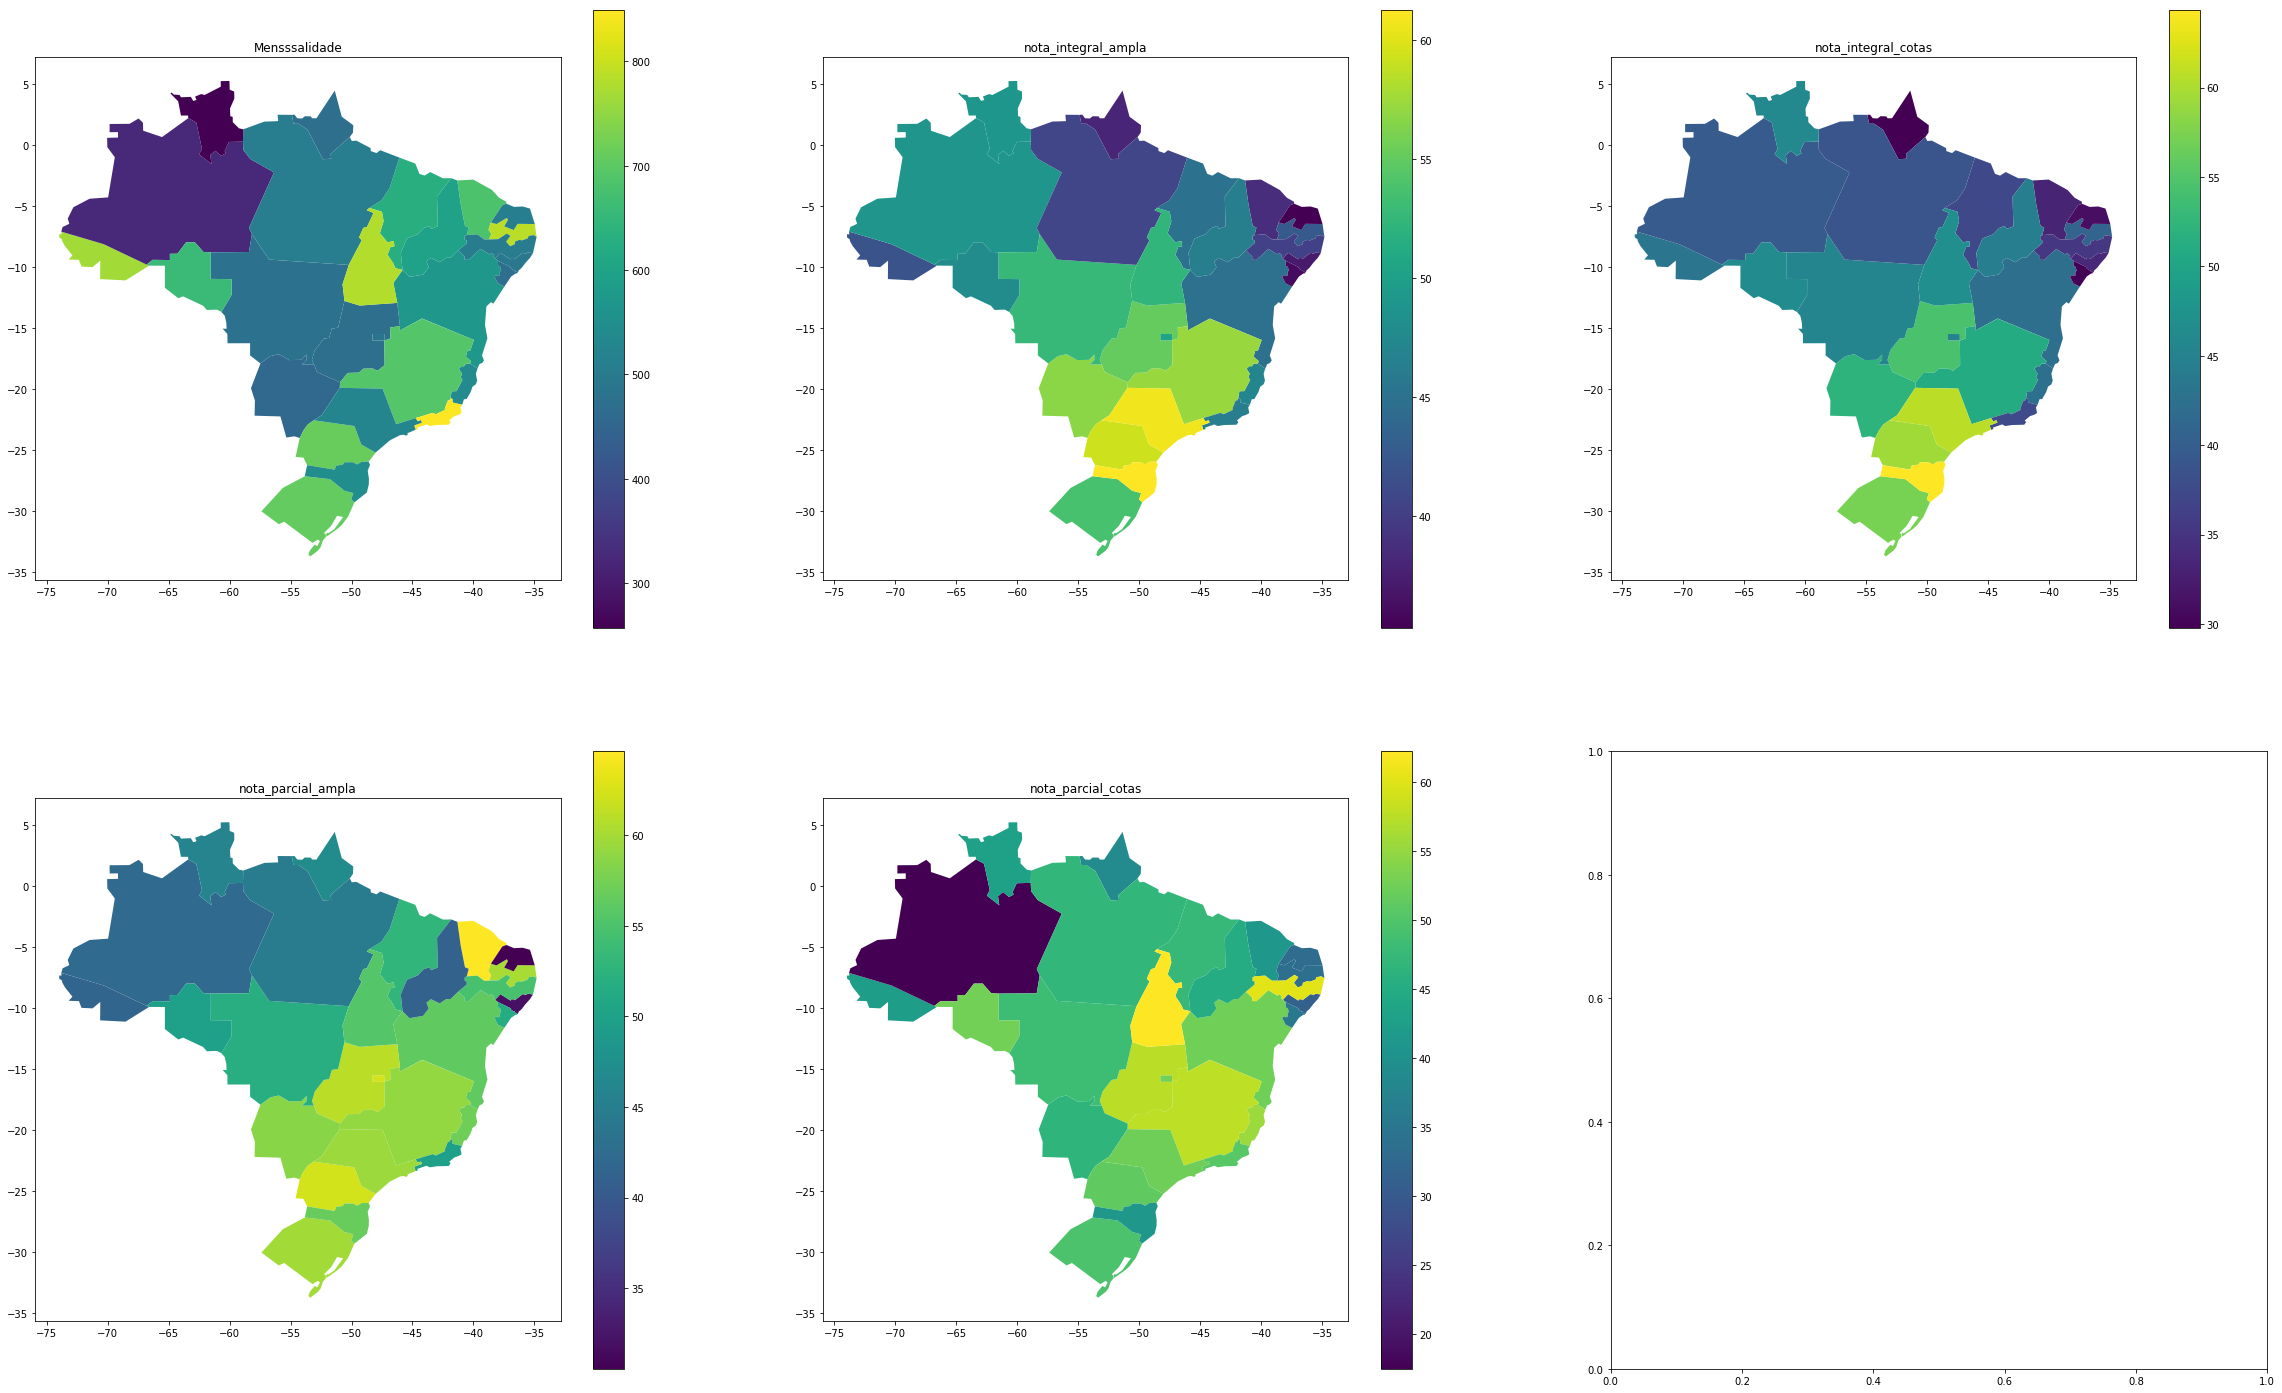

In [17]:
# Agrupando ambos os databases pela coluna id, utilizando o desvio padrão das linhas do prouni

df1=df.groupby("id").std()

df3=pd.merge(df1,geodata,on="id")
gdf3 = geopandas.GeoDataFrame(
    df3, geometry=df3["geometry"])

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=[40,25])

# Fazendo visualizações das notas (std) por estado

axes[0][0].set_title("Mensalidade")
axes[0][1].set_title("nota_integral_ampla")
axes[0][2].set_title("nota_integral_cotas")
axes[1][0].set_title("nota_parcial_ampla")
axes[1][1].set_title("nota_parcial_cotas")

gdf3.plot(column="mensalidade", ax=axes[0][0], legend=True)
gdf3.plot(column="nota_integral_ampla", ax=axes[0][1], legend=True)
gdf3.plot(column="nota_integral_cotas", ax=axes[0][2], legend=True)
gdf3.plot(column="nota_parcial_ampla", ax=axes[1][0], legend=True)
gdf3.plot(column="nota_parcial_cotas", ax=axes[1][1], legend=True)

Esse é um conjunto de plots para acompanhar o anterior, agora não sabemos só os valores absolutos mas é possível ter uma ideia do quanto eles variam.

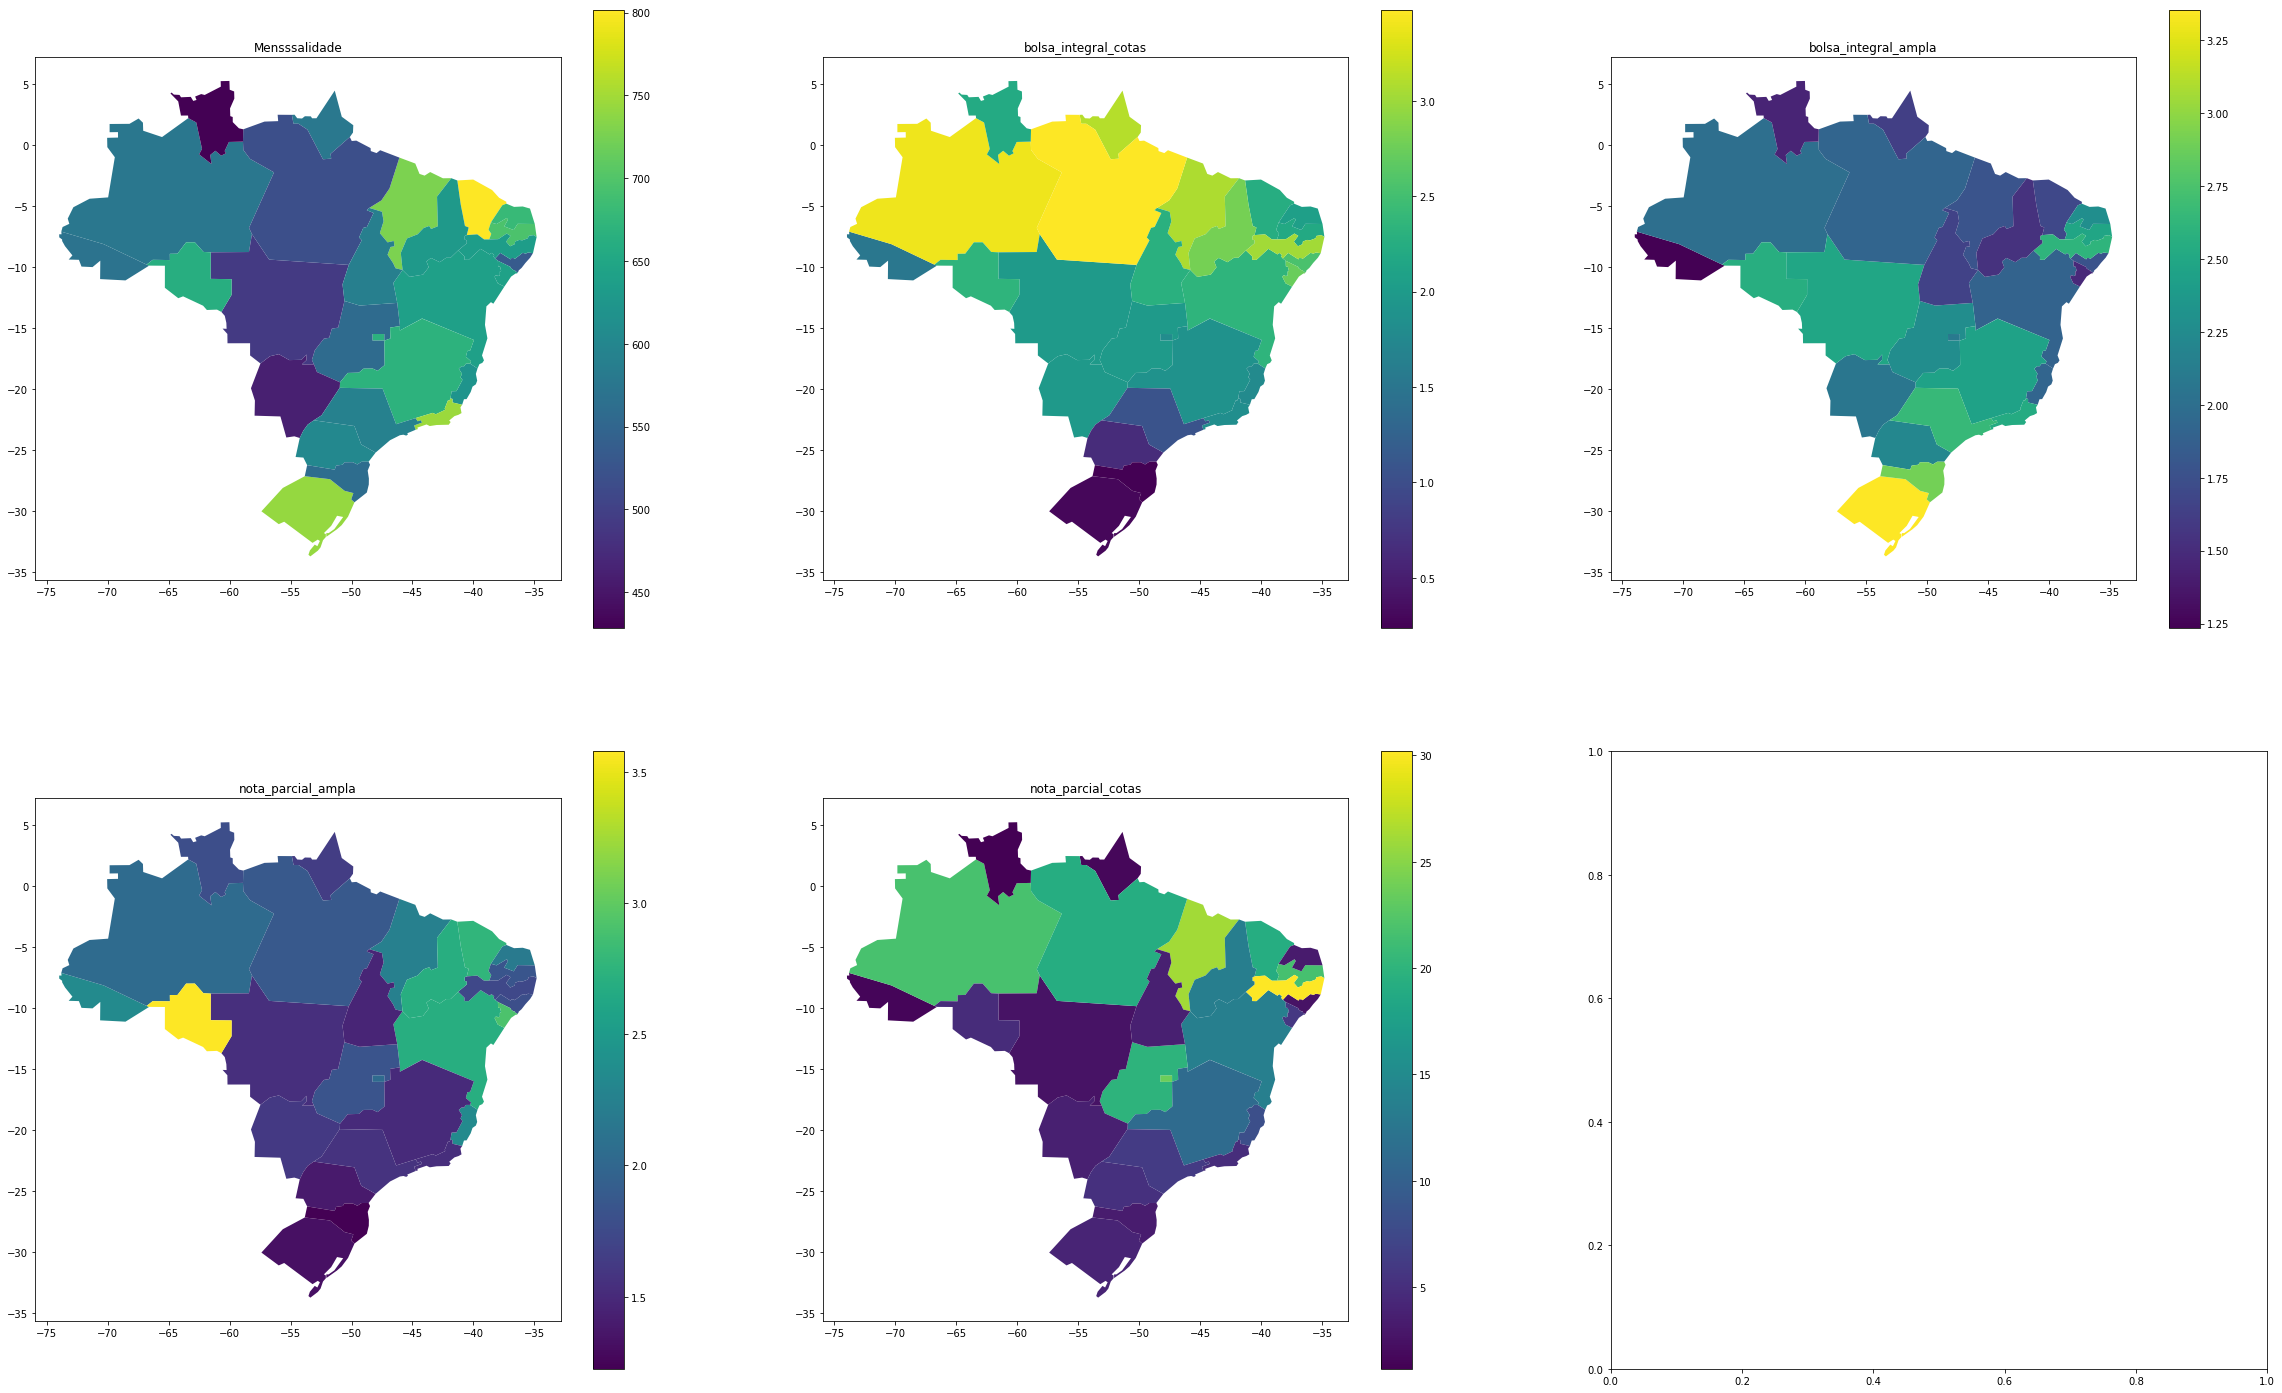

In [18]:
# Agrupando ambos os databases pela coluna id, utilizando a média das linhas do prouni

df1=df.groupby("id").mean()

df3=pd.merge(df1,geodata,on="id")
gdf3 = geopandas.GeoDataFrame(
    df3, geometry=df3["geometry"])

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=[40,25])

# Fazendo visualizações das bolsas (média) por estado

axes[0][0].set_title("Mensalidade")
axes[0][1].set_title("bolsa_integral_cotas")
axes[0][2].set_title("bolsa_integral_ampla")
axes[1][0].set_title("nota_parcial_ampla")
axes[1][1].set_title("nota_parcial_cotas")

gdf3.plot(column="mensalidade", ax=axes[0][0], legend=True)
gdf3.plot(column="bolsa_integral_cotas", ax=axes[0][1], legend=True)
gdf3.plot(column="bolsa_integral_ampla", ax=axes[0][2], legend=True)
gdf3.plot(column="bolsa_parcial_cotas", ax=axes[1][0], legend=True)
gdf3.plot(column="bolsa_parcial_ampla", ax=axes[1][1], legend=True)

E para finalizar, uma terceira visualização com as médias destes mesmos valores.

Essas visualizações, mesmo simples, passam a informação de maneira muito mais eficiente do que uma lista númerica ou com gráficos "convencionais", se provando muito eficiente para uma primeira análise e exploração dos dados e certamente capaz de gerar bons "insights" para prosseguir uma pesquisa a fundo.
Isso tudo sem precisar de nenhum ambiente ou ferramenta complexa, o grupo optou por utilizar o Sqlite justamente por isso, é uma forma eficiente de realizar compartilhamento de uma banco de dados para uma exploração como esta em um notebook que foi editado online (inicialmente com o jupyterhub, mas substituido pelo pela ferramenta Github.dev para testá-la), além de permitir uma manipulação prática e facil com o SQLAlchemy.

Algumas considerações:
 * Algumas visualizações acabam sendo díficeis de realizar por falta de dados, esse problema foi enfrentado no início desse trabalho devido a expectativa de encontrar uma porcentagem considerávelmente maior de cidades cobertas pelos dados do Prouni, e em seguida após uma tentativa de utilizar SPARQL para plotar as localizações das instituições de ensino, que na maioria das vezes não possuiam esses dados na base da wikidata.
 * Prosseguindo dos mesmos obstáculos, a falta de formalidade de certos dados também foi problemática. Mudando para a utilização dos codigos das Unidades Federativas esse problema não ocorreu pois é algo extremamente padronizado, e além disso como são poucos valores, caso algum falhasse seria facil perceber nos plots. Já no caso das cidades seria necessário muito mais atenção para ter certeza de que a comunicação entre diferentes fontes de dados funcionasse. O mesmo se aplica à nossa tentativa de utilizar o SPARQL, isso pois os nomes das universidades/faculdades era tudo o que possuíamos de informação específica sobre elas, e eles não são nem um pouco padronizados. (Não tivemos sucesso tentando buscar as instituições de ensino com um motor de busca ou por comparação com todas as faculdades do Brasil, devido à falta de informação e de padronização principalmente).

<hr>
<div style="text-align: right; font-size: 12px; line-height: 10px;"> 
    <p>Um trabalho feito por:</p>
    <p>Gustavo Sanches</p>
    <p>Lucas Treuke</p></div>